In [4]:
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, mean_proc='VGG16_ImageNet', test_size=0.1)

# ResNet50 Layer Transfer

## Using Flatten

In [3]:
model_name = 'ResNet50-Layer-Transfer'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(img_rows, img_cols, img_channel))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dropout(0.75)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
aug_ratio = 1
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/100
167/167 [==============================] - 17s 100ms/step - loss: 4.2878 - acc: 0.1855 - val_loss: 3.1853 - val_acc: 0.0903

Epoch 00001: val_loss improved from inf to 3.18534, saving model to ./saved_models/ResNet50-Layer-Transfer.h5
Epoch 2/100
167/167 [==============================] - 16s 95ms/step - loss: 2.4445 - acc: 0.4075 - val_loss: 3.6015 - val_acc: 0.0936

Epoch 00002: val_loss did not improve from 3.18534
Epoch 3/100
167/167 [==============================] - 16s 94ms/step - loss: 1.8204 - acc: 0.4990 - val_loss: 3.8819 - val_acc: 0.0936

Epoch 00003: val_loss did not improve from 3.18534
Epoch 4/100
167/167 [==============================] - 16s 95ms/step - loss: 1.4975 - acc: 0.5761 - val_loss: 4.1341 - val_acc: 0.0936

Epoch 00004: val_loss did not improve from 3.18534
Epoch 5/100
167/167 [==============================] - 16s 95ms/step - loss: 1.3464 - acc: 0.6124 - val_loss: 4.4364 - val_acc: 0.0936

Epoch 00005: val_loss did not improve from 3.18534
Epoch

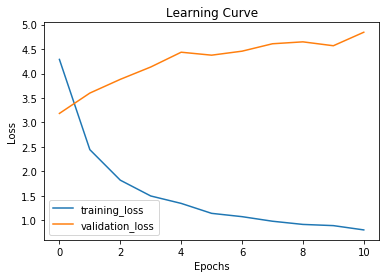

In [5]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

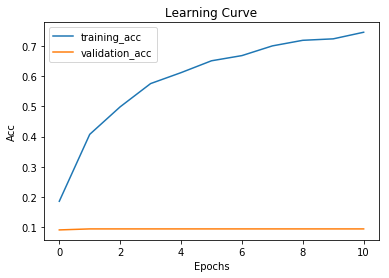

In [6]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [7]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='VGG16_ImageNet')

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 2s 6ms/step
Validation loss: 3.1853416603943177
Validation accuracy: 0.09030100354382824


## Using GlobalAveragePooling2D

In [5]:
model_name = 'ResNet50-Layer-Transfer-GlobalAveragePooling2D'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(img_rows, img_cols, img_channel))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.75)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [6]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
aug_ratio = 1
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/100
167/167 [==============================] - 17s 99ms/step - loss: 3.5424 - acc: 0.0782 - val_loss: 2.8663 - val_acc: 0.1405

Epoch 00001: val_loss improved from inf to 2.86627, saving model to ./saved_models/ResNet50-Layer-Transfer-GlobalAveragePooling2D.h5
Epoch 2/100
167/167 [==============================] - 15s 93ms/step - loss: 3.1695 - acc: 0.1033 - val_loss: 2.8237 - val_acc: 0.1405

Epoch 00002: val_loss improved from 2.86627 to 2.82373, saving model to ./saved_models/ResNet50-Layer-Transfer-GlobalAveragePooling2D.h5
Epoch 3/100
167/167 [==============================] - 15s 93ms/step - loss: 3.0432 - acc: 0.1120 - val_loss: 2.7997 - val_acc: 0.1405

Epoch 00003: val_loss improved from 2.82373 to 2.79974, saving model to ./saved_models/ResNet50-Layer-Transfer-GlobalAveragePooling2D.h5
Epoch 4/100
167/167 [==============================] - 16s 93ms/step - loss: 2.8571 - acc: 0.1524 - val_loss: 2.7901 - val_acc: 0.1405

Epoch 00004: val_loss improved from 2.79974 to 2.

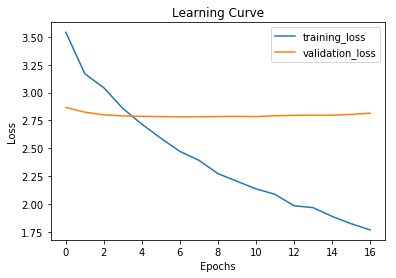

In [7]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

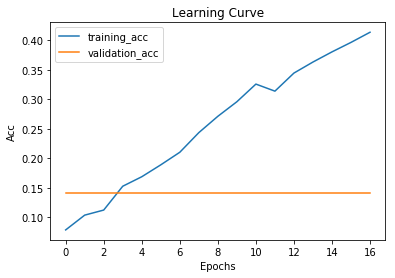

In [8]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [9]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='VGG16_ImageNet')

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 2s 6ms/step
Validation loss: 2.781286822513593
Validation accuracy: 0.14046822742474915


# ResNet50 Fine Tuning

In [8]:
model_name = 'ResNet50-Fine-Tuning'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(img_rows, img_cols, img_channel))

# for layer in base_model.layers:
#     layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dropout(0.75)(x)
# x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
aug_ratio = 1
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/100
167/167 [==============================] - 44s 261ms/step - loss: 6.0189 - acc: 0.1374 - val_loss: 2.2243 - val_acc: 0.3779

Epoch 00001: val_loss improved from inf to 2.22429, saving model to ./saved_models/ResNet50-Fine-Tuning.h5
Epoch 2/100
167/167 [==============================] - 38s 226ms/step - loss: 4.1593 - acc: 0.2643 - val_loss: 1.2900 - val_acc: 0.6154

Epoch 00002: val_loss improved from 2.22429 to 1.29005, saving model to ./saved_models/ResNet50-Fine-Tuning.h5
Epoch 3/100
167/167 [==============================] - 38s 227ms/step - loss: 3.1251 - acc: 0.3775 - val_loss: 0.8228 - val_acc: 0.6990

Epoch 00003: val_loss improved from 1.29005 to 0.82284, saving model to ./saved_models/ResNet50-Fine-Tuning.h5
Epoch 4/100
167/167 [==============================] - 38s 228ms/step - loss: 2.5771 - acc: 0.4787 - val_loss: 0.6382 - val_acc: 0.7893

Epoch 00004: val_loss improved from 0.82284 to 0.63817, saving model to ./saved_models/ResNet50-Fine-Tuning.h5
Epoch 5/100


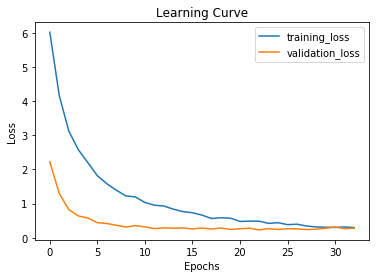

In [10]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

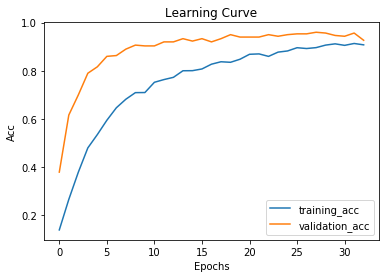

In [11]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [12]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='VGG16_ImageNet')

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 2s 8ms/step
Validation loss: 0.22820130967376223
Validation accuracy: 0.9498327769164656
